In [24]:
from glob import glob

import numpy as np
import matplotlib.pylab as plt
%matplotlib inline

import fit_peak as fit
import indexations
%load_ext autoreload

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [25]:
def read_XRD_csv(path):
    # Read header
    stop = False
    with open(path, 'r') as f:
        csv = f.readlines()
        info = {}
        for k, line in enumerate(csv):
            if stop:
                info['columns'] = [v.strip('" \n') for v in line.split(',')]
                break
            if "measurement conditions" in line.lower():
                continue
            if "scan points" in line.lower():
                skip_header = k + 2
                stop = True

            key, *values = line.split(',')
            values = [v.strip('" \n') for v in values]
            info[key.strip()] = values[0] if len(values)==1 else values

    # Read the values
    data = np.genfromtxt(path,
                         skip_header=skip_header,
                         delimiter=',')
    return data, info

In [26]:
class Theta2Theta():
    """ theta two theta measure """
    list_of_colors = plt.get_cmap('tab10').colors # or 'tab10'
    color_pointer = 0
    def __init__(self,
                 filepath,
                 name=None,
                 materials=None,
                 color=None):
        
        # Load the data
        data, info = read_XRD_csv(filepath)

        self.path = filepath
        self.deux_theta = data[:, 0]
        self.I = data[:, 1]
        self.info = info
        
        self.name = name 
        self.label = name if name else filepath.split('/')[-1].replace('.csv', '')
        self.label = self.label.replace('_', ' ')
        
        self.color = Theta2Theta.list_of_colors[Theta2Theta.color_pointer]
        Theta2Theta.color_pointer = (Theta2Theta.color_pointer+1) % len(Theta2Theta.list_of_colors)
       
    def plot(self, norm=False):
        I = self.I
        if norm:
            I = self.I / np.max(self.I)
        plt.plot(self.deux_theta, I, color=self.color, label=self.label)
        plt.xlabel('deux theta (deg)');
        plt.ylabel('I');

In [27]:
filelist = sorted(glob("./data/theta2theta/*.csv"))
filelist.extend(glob("./data/theta2theta/zoom/*.csv"))

In [28]:
# Load data
measures = [Theta2Theta(path) for path in filelist]

## all data

In [29]:
# rename label
for m in measures:
    m.label = m.label.replace('2theta-omega serpentin ', '')
    m.label = m.label.replace('theta2theta ', '')

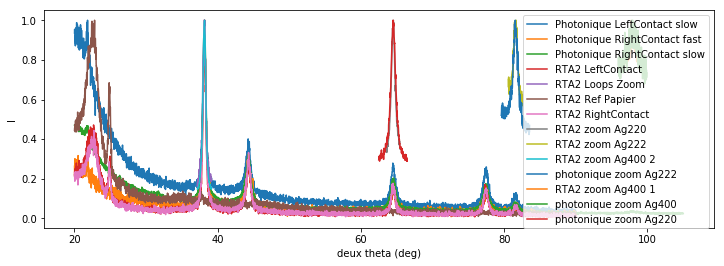

In [30]:
plt.figure(1, figsize=(12, 4))
for m in measures:
    m.plot(norm=True)
    
plt.legend();

In [31]:
for k, m in enumerate(measures):
    print(k, m.label)

0 Photonique LeftContact slow
1 Photonique RightContact fast
2 Photonique RightContact slow
3 RTA2 LeftContact
4 RTA2 Loops Zoom
5 RTA2 Ref Papier
6 RTA2 RightContact
7 RTA2 zoom Ag220
8 RTA2 zoom Ag222
9 RTA2 zoom Ag400 2
10 photonique zoom Ag222
11 RTA2 zoom Ag400 1
12 photonique zoom Ag400
13 photonique zoom Ag220


## Theoritical peak positions

In [32]:
# Constantes
lmbda = 1.5405929 # Ang., x-ray wavelength
wavelength = 1.5405980 # Ang

#a_Nb = 3.3063 # Ang.
#a_Si = 5.4311946 # Ang.
#a_LaB6 = 4.15682 # Ang.   https://www-s.nist.gov/srmors/certificates/660c.pdf

#LaB6 = indexations.Material('LaB6', 'cubic', a_LaB6)
#Nb = indexations.Material('Nb', 'bcc', a_Nb)
#Cu = indexations.Material('Cu', 'fcc', a_Cu, color='darkorange')

a_Ag = 4.0853  # Ang. 
Ag = indexations.Material('Ag', 'fcc', a_Ag, color='darkgray')

peaks = indexations.theoretical_peaks([Ag, ],
                                      wavelength,
                                      deuxtheta_max=100)

## Reference graph

Time per step: 3.00


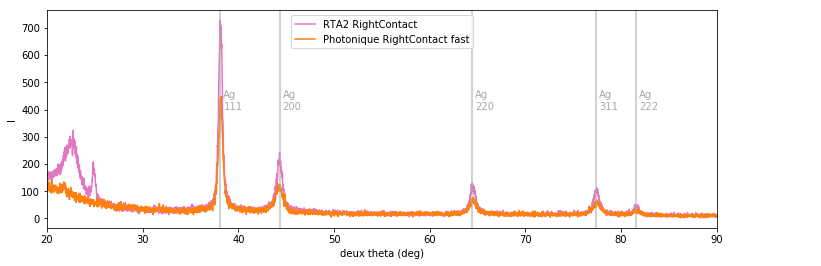

In [33]:
plt.figure(1, figsize=(12, 4))
measures[6].plot()
measures[1].plot()
plt.legend();
print('Time per step:', measures[1].info['Time per step'])

plt.xlim(measures[6].deux_theta.min(), measures[6].deux_theta.max())
for peak in peaks:

    plt.axvline(x=peak['deuxtheta_theo'],
                color=peak['material'].color,
                alpha=0.7)
    
    hkl = peak['hkl']
    line_name = 'Ag\n%s' % ''.join([str(i) for i in hkl])
    plt.annotate(line_name,
                 (peak['deuxtheta_theo'], 400),
                 xytext=(3, 0),
                 xycoords='data',
                 textcoords='offset pixels',
                 rotation=0,
                 color=peak['material'].color)

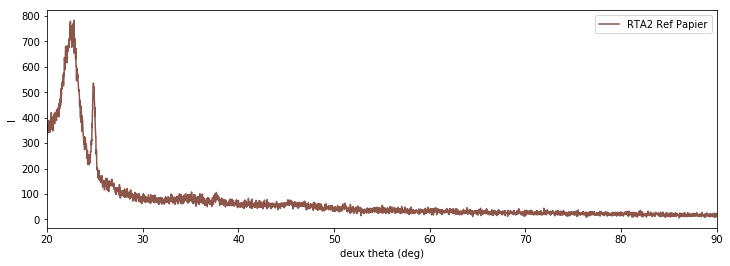

In [34]:
plt.figure(1, figsize=(12, 4))
measures[5].plot()
plt.legend();
plt.xlim(measures[5].deux_theta.min(), measures[5].deux_theta.max());

# Fit peaks

In [35]:
peaks

[{'hkl': [1, 1, 1], 'deuxtheta_theo': 38.123238197989124, 'material': Ag},
 {'hkl': [2, 0, 0], 'deuxtheta_theo': 44.309280586033985, 'material': Ag},
 {'hkl': [2, 2, 0], 'deuxtheta_theo': 64.45885194686568, 'material': Ag},
 {'hkl': [3, 1, 1], 'deuxtheta_theo': 77.41757408441481, 'material': Ag},
 {'hkl': [2, 2, 2], 'deuxtheta_theo': 81.56201823869293, 'material': Ag},
 {'hkl': [4, 0, 0], 'deuxtheta_theo': 97.91371319202413, 'material': Ag}]

In [36]:
def fit_theta2theta(measure, x0, x_range):
    x, y = measure.deux_theta, measure.I
    mask = (x < (x0 + x_range)) & (x > (x0 - x_range))
    x, y = x[mask], y[mask]
    try:
        deuxTheta_fit, fwhm, fit_function = fit.fit_peak(x, y, function='pseudoVoigt')
        
        y_fit = fit_function(x)
        x0_std, fwhm_std = fit.estimate_std(x, y_fit)
        
        return {'deuxtheta_fit':deuxTheta_fit,
                'std_deuxtheta':x0_std,
                'fwhm_fit':fwhm,
                'std_fwhm':fwhm_std,
                'fit_function':fit_function}
    
    except RuntimeError:
            return None

In [37]:
def index_and_fit(measure, peaks, x_range=3, verbose=True):
    if verbose:
        print(measure.label, end=': ')
    fitted_peaks = []
    for peak in peaks:
        x0 = peak['deuxtheta_theo']

        if x0 > np.max(measure.deux_theta) or x0 < np.min(measure.deux_theta):
            continue
        
        results = fit_theta2theta(measure, x0, x_range)
        if results:
            results.update(peak)
            fitted_peaks.append(results)
            if verbose:
                print('%.2f° '%results['deuxtheta_fit'], end='')

    if verbose:
        print('')
    return fitted_peaks

In [38]:
# fit all measures
fit_results = [index_and_fit(m, peaks) for m in measures]

Photonique LeftContact slow: 38.13° 44.27° 64.50° 77.44° 81.58° 
Photonique RightContact fast: 38.15° 44.28° 64.53° 77.45° 81.65° 
Photonique RightContact slow: 38.15° 44.28° 64.52° 77.43° 81.59° 98.00° 
RTA2 LeftContact: 38.14° 44.31° 64.50° 77.46° 81.61° 
RTA2 Loops Zoom: 38.14° 
RTA2 Ref Papier: 37.70° 45.35° 
RTA2 RightContact: 38.14° 44.31° 64.51° 77.43° 81.62° 
RTA2 zoom Ag220: 64.50° 
RTA2 zoom Ag222: 81.59° 
RTA2 zoom Ag400 2: 38.14° 
photonique zoom Ag222: 81.58° 
RTA2 zoom Ag400 1: 97.97° 
photonique zoom Ag400: 97.96° 
photonique zoom Ag220: 64.51° 


In [39]:
def plot_FWHM_graph(selection):
    plt.figure(figsize=(10, 6))
    for measure, fitted_peaks in selection:
        label = measure.label

        linestyle = '--' #if 'plate' in label else '-'

        color = measure.color
        markerfacecolor = color

        deuxtheta = [p['deuxtheta_fit'] for p in fitted_peaks]
        fwhm = [p['fwhm_fit'] for p in fitted_peaks]
        std = [p['std_fwhm'] for p in fitted_peaks]
        plt.plot(deuxtheta, fwhm,
                 linestyle=linestyle, label=label, color=color, marker='o',
                 markerfacecolor=markerfacecolor)
        plt.errorbar(deuxtheta, fwhm, yerr=std,
                     xerr=None,
                     fmt='None',
                     capsize=5,
                     ecolor=color)

    for peak in peaks:
        hkl = peak['hkl']
        line_name = '%s' % ''.join([str(i) for i in hkl])
        plt.annotate(line_name,
                     (peak['deuxtheta_theo'], 1),
                     xytext=(1, 1),
                     xycoords='data',
                     textcoords='offset pixels',
                     rotation=0,
                     color='k')

    plt.xlabel('2theta (degree)'); plt.ylabel('FWHM (degree)');
    plt.legend(); plt.grid(axis='y', which='both', alpha=0.2)

In [40]:
for k, m in enumerate(measures):
    print(k, m.label)

0 Photonique LeftContact slow
1 Photonique RightContact fast
2 Photonique RightContact slow
3 RTA2 LeftContact
4 RTA2 Loops Zoom
5 RTA2 Ref Papier
6 RTA2 RightContact
7 RTA2 zoom Ag220
8 RTA2 zoom Ag222
9 RTA2 zoom Ag400 2
10 photonique zoom Ag222
11 RTA2 zoom Ag400 1
12 photonique zoom Ag400
13 photonique zoom Ag220


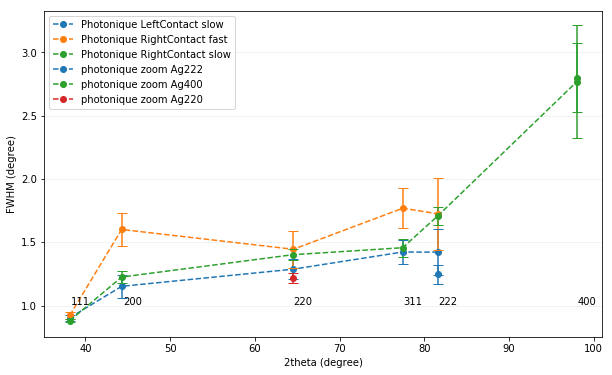

In [41]:
selection_photo = [u for k, u in enumerate(zip(measures, fit_results)) if 'photo' in u[0].label.lower()]
plot_FWHM_graph(selection_photo)

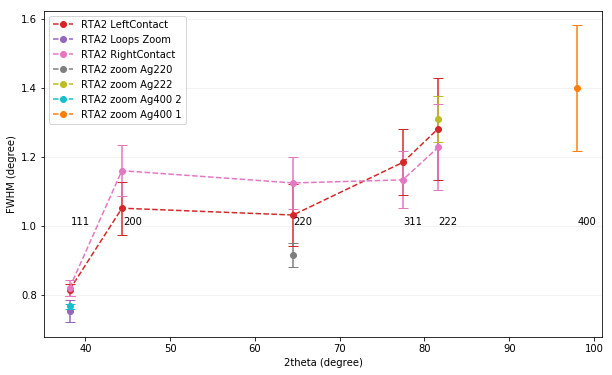

In [42]:
selection_RTA = [u for k, u in enumerate(zip(measures, fit_results))
             if 'rta' in u[0].label.lower() and 'papier' not in u[0].label.lower()]
plot_FWHM_graph(selection_RTA)

## Williamson Hall
http://pd.chem.ucl.ac.uk/pdnn/peaks/sizedet.htm

In [44]:
def plot_WilliamsonHall_graph(selection, hkl):
    plt.figure(figsize=(10, 6))
    for measure, fitted_peaks in selection:
        label = measure.label

        linestyle = '--' #if 'plate' in label else '-'

        color = measure.color
        markerfacecolor = color

        deuxtheta = np.array([p['deuxtheta_fit'] for p in fitted_peaks if p['hkl'] in hkl])
        fwhm = np.array([p['fwhm_fit'] for p in fitted_peaks  if p['hkl'] in hkl])
        
        theta = np.pi/180* deuxtheta/2
        x = np.sin(theta)
        y = fwhm*np.cos(theta)
    
        std = np.array([p['std_fwhm'] for p in fitted_peaks  if p['hkl'] in hkl])
        plt.plot(x, y,
                 linestyle=linestyle, label=label, color=color, marker='o',
                 markerfacecolor=markerfacecolor)
        plt.errorbar(x, y, yerr=std*np.cos(theta),
                     xerr=None,
                     fmt='None',
                     capsize=5,
                     ecolor=color)

    plt.xlabel('sin(theta)');
    plt.ylabel('FWHM cos(theta)');
    plt.legend(); plt.grid(axis='y', which='both', alpha=0.2);
    plt.xlim(0, 1);

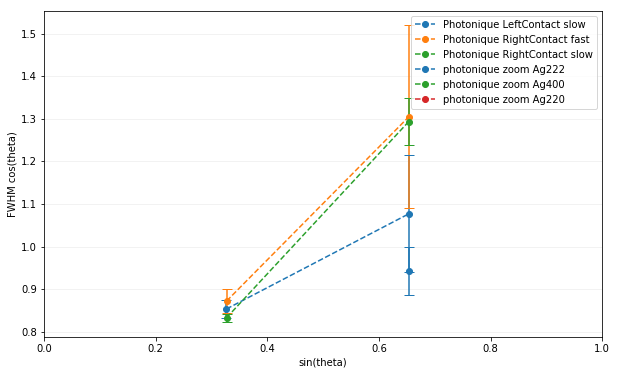

In [45]:
selection_photo = [u for k, u in enumerate(zip(measures, fit_results))
                   if k==2]
selection_photo = [u for k, u in enumerate(zip(measures, fit_results)) if 'photo' in u[0].label.lower()]

hkl = [[1, 1, 1], [2, 2, 2]]#, [2,0,0], [4, 0, 0]]
plot_WilliamsonHall_graph(selection_photo, hkl)

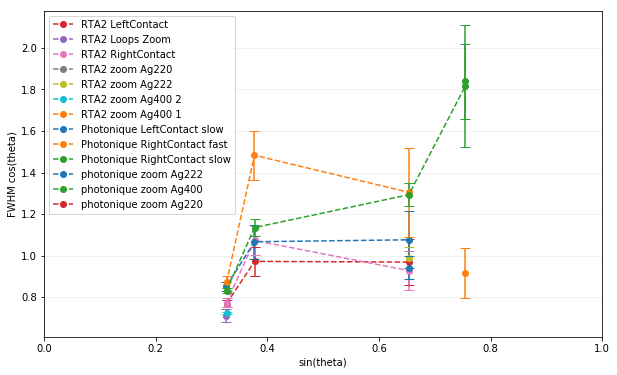

In [47]:
selection_RTA = [u for k, u in enumerate(zip(measures, fit_results))
             if 'rta' in u[0].label.lower() and 'papier' not in u[0].label.lower() ] #and len(u[1])>1

selection_photo = [u for k, u in enumerate(zip(measures, fit_results)) if 'photo' in u[0].label.lower()]

hkl = [[1, 1, 1], [2, 2, 2], [2,0,0], [4, 0, 0]]
plot_WilliamsonHall_graph(selection_RTA+selection_photo, hkl)

Formule de Scherrer
$$
B cos(\theta) = \frac{k \lambda}{L}
$$

In [48]:
bcosTheta = 1.1*np.pi/180
k = 0.6
L = wavelength*k/bcosTheta
print(L*10, "nm")

481.4714363252486 nm
